In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import papermill as pm
import json
import matplotlib.pyplot as plt
import os
import uuid
from db import Result
import ast
import math
from vis.visualization import visualize_cam, visualize_saliency, overlay
from vis.utils.utils import load_img, normalize, find_layer_idx


pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.
/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [3]:
from evaluate import plot_learning_curve, plot_accuracy_curve, load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, plot_multiple_grad_cam, plot_precision_recall

In [4]:
from data_gen import data
from run import characterize_data
from config import config

In [5]:
# Parameters
UUID = "23c07175-158e-4ae6-957a-92d59edbddc7"
SELECTIONS = "None"
TSNE_PERPLEXITY = 10


In [6]:
SELECTIONS = eval(SELECTIONS)

# Learning Curve

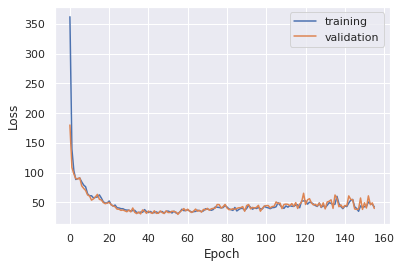

In [8]:
result = Result.query.filter(Result.uuid == UUID).first()
fig = plot_learning_curve(result)
fig.savefig("figures/learning_curves/{}-learning_curve.svg".format(UUID))

# Accuracy Trend

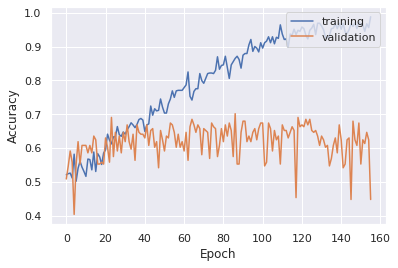

In [8]:
fig = plot_accuracy_curve(result)
fig.savefig("figures/accuracy/{}-accuracy.svg".format(UUID))

In [9]:
print("input form:", result.input_form)

input form: t2


In [9]:
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, UUID, result.model)

In [10]:
train, validation, test = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

  0%|          | 0/708 [00:00<?, ?it/s]

Training points = 708
Benign: 378, Intermediate: 330, Malignant: 0

Validation points = 202
Benign: 108, Intermediate: 94, Malignant: 0

Testing points = 101
Benign: 54, Intermediate: 47, Malignant: 0
bone-penn-281
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 2/708 [00:00<02:52,  4.10it/s]

bone-china-005
Does this patient have T2 available? True
I'm doing the thing.
bone-china-080
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 3/708 [00:00<02:29,  4.72it/s]

bone-penn-330
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 4/708 [00:01<03:47,  3.09it/s]

bone-penn-95
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 6/708 [00:01<03:10,  3.68it/s]

bone-penn-564
Does this patient have T2 available? True
I'm doing the thing.
bone-china-167
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 8/708 [00:01<02:31,  4.61it/s]

bone-hup-145
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-567
Does this patient have T2 available? True
I'm doing the thing.


  1%|▏         | 10/708 [00:02<03:28,  3.35it/s]

bone-china-117
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-589
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 12/708 [00:03<02:56,  3.94it/s]

bone-china-106
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-613
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 13/708 [00:03<02:33,  4.53it/s]

bone-penn-542
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 15/708 [00:03<02:36,  4.41it/s]

bone-china-041
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-328
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 16/708 [00:04<04:29,  2.56it/s]

bone-penn-590
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 17/708 [00:04<04:01,  2.86it/s]

bone-penn-159
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 18/708 [00:05<03:40,  3.13it/s]

bone-penn-347
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 19/708 [00:05<03:31,  3.25it/s]

bone-hup-264
Does this patient have T2 available? False
T2 image unavailable
bone-penn-518
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 21/708 [00:05<03:05,  3.70it/s]

bone-hup-287
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 23/708 [00:06<02:53,  3.96it/s]

bone-hup-301
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-278
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 24/708 [00:06<02:28,  4.62it/s]

bone-penn-545
Does this patient have T2 available? False
T2 image unavailable
bone-hup-266
Does this patient have T2 available? True
I'm doing the thing.


  4%|▎         | 26/708 [00:06<02:26,  4.65it/s]

bone-hup-326
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 29/708 [00:07<03:27,  3.27it/s]

bone-hup-140
Does this patient have T2 available? False
T2 image unavailable
bone-china-039
Does this patient have T2 available? True
I'm doing the thing.
bone-china-033
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 30/708 [00:07<02:49,  4.00it/s]

bone-penn-476
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-612
Does this patient have T2 available? True
I'm doing the thing.


  5%|▍         | 33/708 [00:09<03:13,  3.48it/s]

bone-china-002
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-294

  5%|▍         | 35/708 [00:09<02:26,  4.60it/s]


Does this patient have T2 available? False
T2 image unavailable
bone-penn-509
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-293
Does this patient have T2 available? True
I'm doing the thing.


  5%|▌         | 37/708 [00:09<02:03,  5.43it/s]

bone-hup-142
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-527
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 39/708 [00:09<02:07,  5.23it/s]

bone-penn-503
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-413
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 41/708 [00:10<01:57,  5.68it/s]

bone-penn-303
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-293
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 42/708 [00:10<01:52,  5.90it/s]

bone-penn-535
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 44/708 [00:10<02:20,  4.72it/s]

bone-penn-481
Does this patient have T2 available? True
I'm doing the thing.
bone-china-022
Does this patient have T2 available? True
I'm doing the thing.


  6%|▋         | 45/708 [00:11<02:06,  5.26it/s]

bone-penn-107
Does this patient have T2 available? True
I'm doing the thing.


  6%|▋         | 46/708 [00:11<02:56,  3.75it/s]

bone-penn-276
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 47/708 [00:12<04:45,  2.32it/s]

bone-hup-129
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 49/708 [00:13<04:12,  2.61it/s]

bone-china-168
Does this patient have T2 available? True
I'm doing the thing.
bone-china-035
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 51/708 [00:13<02:56,  3.72it/s]

bone-china-155
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-323
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 53/708 [00:13<02:44,  3.98it/s]

bone-china-014
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-562
Does this patient have T2 available? False
T2 image unavailable
bone-china-100
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 55/708 [00:14<02:07,  5.10it/s]

bone-penn-561
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 57/708 [00:14<02:16,  4.78it/s]

bone-penn-304
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-560
Does this patient have T2 available? False
T2 image unavailable
bone-penn-473
Does this patient have T2 available? True
I'm doing the thing.


  9%|▊         | 61/708 [00:14<01:35,  6.77it/s]

bone-china-032
Does this patient have T2 available? True
I'm doing the thing.
bone-china-070
Does this patient have T2 available? True
I'm doing the thing.
bone-china-043
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 63/708 [00:15<01:32,  7.00it/s]

bone-penn-346
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-99
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 64/708 [00:15<02:36,  4.11it/s]

bone-penn-297
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 65/708 [00:15<02:29,  4.29it/s]

bone-china-136
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-88
Does this patient have T2 available? False
T2 image unavailable
bone-china-151
Does this patient have T2 available? True
I'm doing the thing.


 10%|▉         | 69/708 [00:16<02:02,  5.22it/s]

bone-china-038
Does this patient have T2 available? True
I'm doing the thing.
bone-china-160
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 71/708 [00:16<01:58,  5.36it/s]

bone-china-132
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-90
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 73/708 [00:17<01:48,  5.86it/s]

bone-china-133
Does this patient have T2 available? True
I'm doing the thing.
bone-china-124
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 75/708 [00:17<01:52,  5.65it/s]

bone-china-008
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-284
Does this patient have T2 available? False
T2 image unavailable
bone-penn-552
Does this patient have T2 available? False
T2 image unavailable
bone-hup-297
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 78/708 [00:18<02:24,  4.36it/s]

bone-penn-83
Does this patient have T2 available? True
I'm doing the thing.


 11%|█▏        | 81/708 [00:18<02:05,  5.01it/s]

bone-penn-89
Does this patient have T2 available? False
T2 image unavailable
bone-china-060
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 82/708 [00:19<02:04,  5.02it/s]

bone-penn-471
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-317
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 83/708 [00:19<01:57,  5.32it/s]

bone-penn-150
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 84/708 [00:19<02:16,  4.58it/s]

bone-penn-332
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 86/708 [00:20<02:22,  4.36it/s]

bone-china-023
Does this patient have T2 available? True
I'm doing the thing.
bone-china-162
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-525
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 88/708 [00:21<03:04,  3.36it/s]


################################################################################
Exception occurred for: outcome_pos   0.000
outcome_neg   1.000
outcome_3     1.000
sort              -
volume        0.140
Name: bone-penn-525, dtype: object
index 161 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 13%|█▎        | 91/708 [00:22<02:52,  3.58it/s]

bone-china-051
Does this patient have T2 available? True
I'm doing the thing.
bone-china-126
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 92/708 [00:22<02:42,  3.78it/s]

bone-penn-497
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-630
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 95/708 [00:22<02:17,  4.47it/s]

bone-penn-282
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-291
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▎        | 96/708 [00:22<02:05,  4.87it/s]

bone-penn-100
Does this patient have T2 available? False
T2 image unavailable
bone-penn-570
Does this patient have T2 available? False
T2 image unavailable
bone-penn-480
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 99/708 [00:23<01:45,  5.76it/s]

bone-penn-536
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 100/708 [00:23<02:29,  4.06it/s]

bone-penn-520
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 101/708 [00:23<02:24,  4.21it/s]

bone-hup-119
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 102/708 [00:24<02:19,  4.33it/s]

bone-penn-82
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▍        | 104/708 [00:24<02:26,  4.11it/s]

bone-china-107
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-327
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▍        | 106/708 [00:25<03:12,  3.12it/s]

bone-penn-109
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-125
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 108/708 [00:25<02:24,  4.14it/s]

bone-hup-257
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-269
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 109/708 [00:26<02:29,  4.01it/s]

bone-penn-312
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 112/708 [00:27<03:01,  3.28it/s]

bone-penn-136
Does this patient have T2 available? False
T2 image unavailable
bone-penn-382
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-108
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 114/708 [00:27<03:21,  2.94it/s]

bone-hup-155
Does this patient have T2 available? True
I'm doing the thing.
bone-china-129
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▋        | 116/708 [00:28<02:24,  4.10it/s]

bone-china-068
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-548
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 118/708 [00:28<02:22,  4.15it/s]

bone-china-170
Does this patient have T2 available? True
I'm doing the thing.
bone-china-075
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 119/708 [00:28<02:00,  4.89it/s]

bone-penn-453
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 120/708 [00:29<02:44,  3.58it/s]

bone-penn-588
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 122/708 [00:29<02:45,  3.55it/s]

bone-penn-549
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-302
Does this patient have T2 available? False
T2 image unavailable
bone-penn-484
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 125/708 [00:30<02:07,  4.58it/s]

bone-china-010
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-385
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 127/708 [00:31<02:33,  3.79it/s]

bone-china-175
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-584
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 128/708 [00:31<02:10,  4.46it/s]


################################################################################
Exception occurred for: outcome_pos   0.000
outcome_neg   1.000
outcome_3     1.000
sort              -
volume        0.145
Name: bone-penn-584, dtype: object
operands could not be broadcast together with shapes (255,20) (318,20) 
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 340, in mask_image_percentile
    masked = image * segmentation
ValueError: operands could n

 18%|█▊        | 129/708 [00:31<03:01,  3.19it/s]

bone-penn-485
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 130/708 [00:32<03:33,  2.71it/s]

bone-penn-129
Does this patient have T2 available? False
T2 image unavailable
bone-hup-272
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▊        | 132/708 [00:32<03:17,  2.91it/s]

bone-hup-316
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 134/708 [00:33<02:41,  3.55it/s]

bone-penn-280
Does this patient have T2 available? True
I'm doing the thing.
bone-china-078
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 136/708 [00:33<02:05,  4.56it/s]

bone-penn-93
Does this patient have T2 available? True
I'm doing the thing.
bone-china-026
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 137/708 [00:33<01:49,  5.22it/s]

bone-penn-110
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 138/708 [00:34<02:25,  3.93it/s]

bone-penn-289
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 139/708 [00:34<02:40,  3.55it/s]

bone-china-011
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 140/708 [00:34<02:31,  3.76it/s]

bone-penn-491
Does this patient have T2 available? True
I'm doing the thing.


 20%|██        | 143/708 [00:35<01:51,  5.05it/s]

bone-hup-159
Does this patient have T2 available? False
T2 image unavailable
bone-china-069
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-320
Does this patient have T2 available? True
I'm doing the thing.


 20%|██        | 144/708 [00:35<03:29,  2.69it/s]

bone-hup-275
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 146/708 [00:37<04:07,  2.27it/s]

bone-china-089
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-151
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 147/708 [00:37<05:26,  1.72it/s]

bone-hup-265
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 148/708 [00:38<04:30,  2.07it/s]

bone-penn-96
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 149/708 [00:38<05:23,  1.73it/s]

bone-penn-133
Does this patient have T2 available? False
T2 image unavailable
bone-penn-158
Does this patient have T2 available? False
T2 image unavailable
bone-china-079
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 153/708 [00:39<03:10,  2.91it/s]

bone-china-077
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-575
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 156/708 [00:39<02:39,  3.47it/s]

bone-hup-161
Does this patient have T2 available? True
I'm doing the thing.
bone-china-055
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-530
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 158/708 [00:40<01:55,  4.76it/s]

bone-china-163
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-349
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 160/708 [00:40<01:47,  5.09it/s]

bone-china-073
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-325
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 162/708 [00:40<01:43,  5.26it/s]

bone-penn-155
Does this patient have T2 available? True
I'm doing the thing.
bone-china-154
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 164/708 [00:41<01:26,  6.26it/s]

bone-china-066
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-158
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 166/708 [00:41<01:42,  5.26it/s]

bone-penn-498
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-285
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▎       | 167/708 [00:42<02:40,  3.37it/s]

bone-penn-84
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▎       | 168/708 [00:42<03:00,  2.99it/s]

bone-hup-312
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 169/708 [00:42<02:46,  3.24it/s]

bone-penn-296
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 170/708 [00:43<02:52,  3.11it/s]

bone-hup-322
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 171/708 [00:43<03:04,  2.91it/s]

bone-penn-435
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 173/708 [00:44<02:21,  3.77it/s]

bone-penn-572
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-101
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▍       | 175/708 [00:44<02:01,  4.38it/s]

bone-china-147
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-321
Does this patient have T2 available? False
T2 image unavailable
bone-penn-573
Does this patient have T2 available? False
T2 image unavailable
bone-penn-580
Does this patient have T2 available? False
T2 image unavailable
bone-hup-299
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▌       | 179/708 [00:44<01:31,  5.77it/s]

bone-penn-462
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 181/708 [00:45<01:37,  5.40it/s]

bone-penn-153
Does this patient have T2 available? False
T2 image unavailable
bone-penn-521
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 182/708 [00:46<03:43,  2.35it/s]

bone-china-086
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 184/708 [00:46<02:32,  3.43it/s]

bone-penn-333
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-455
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▋       | 186/708 [00:46<02:27,  3.54it/s]

bone-penn-417
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-591
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 188/708 [00:47<02:24,  3.61it/s]

bone-china-138
Does this patient have T2 available? True
I'm doing the thing.
bone-china-112
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 191/708 [00:47<01:35,  5.44it/s]

bone-china-097
Does this patient have T2 available? False
T2 image unavailable
bone-china-065
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-421
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 192/708 [00:48<02:05,  4.12it/s]

bone-penn-148
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 193/708 [00:48<02:07,  4.05it/s]

bone-hup-308
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 195/708 [00:48<01:57,  4.36it/s]

bone-china-145
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-152
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 197/708 [00:49<01:53,  4.52it/s]

bone-penn-586
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-152
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 199/708 [00:49<01:48,  4.70it/s]

bone-china-143
Does this patient have T2 available? True
I'm doing the thing.
bone-china-139
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 200/708 [00:49<01:45,  4.81it/s]

bone-hup-150
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 201/708 [00:50<01:55,  4.38it/s]

bone-hup-298
Does this patient have T2 available? True
I'm doing the thing.
bone-china-127
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 205/708 [00:50<01:20,  6.22it/s]

bone-china-052
Does this patient have T2 available? True
I'm doing the thing.
bone-china-053
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-329
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▉       | 207/708 [00:51<01:53,  4.42it/s]

bone-penn-104
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-556
Does this patient have T2 available? True
I'm doing the thing.


 30%|██▉       | 209/708 [00:51<01:46,  4.68it/s]

bone-china-148
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-331
Does this patient have T2 available? False
T2 image unavailable
bone-china-088
Does this patient have T2 available? True
I'm doing the thing.


 30%|██▉       | 212/708 [00:52<01:28,  5.62it/s]

bone-penn-585
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-146
Does this patient have T2 available? True
I'm doing the thing.


 30%|███       | 213/708 [00:52<01:20,  6.18it/s]

bone-penn-334
Does this patient have T2 available? True
I'm doing the thing.


 30%|███       | 214/708 [00:52<02:27,  3.34it/s]

bone-hup-290
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 217/708 [00:53<02:10,  3.76it/s]

bone-hup-30
Does this patient have T2 available? False
T2 image unavailable
bone-penn-116
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-322
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 219/708 [00:53<01:44,  4.67it/s]

bone-penn-391
Does this patient have T2 available? True
I'm doing the thing.
bone-china-114
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 220/708 [00:53<01:38,  4.94it/s]

bone-penn-375
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 221/708 [00:54<01:38,  4.93it/s]

bone-penn-313
Does this patient have T2 available? True
I'm doing the thing.


 31%|███▏      | 223/708 [00:54<02:05,  3.86it/s]

bone-penn-94
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-277
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 226/708 [00:55<02:13,  3.60it/s]

bone-hup-117
Does this patient have T2 available? False
T2 image unavailable
bone-china-031
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-126
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 227/708 [00:56<02:56,  2.72it/s]

bone-hup-319
Does this patient have T2 available? False
T2 image unavailable
bone-penn-468
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 229/708 [00:57<03:41,  2.16it/s]

bone-china-036
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-327
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 231/708 [00:57<02:52,  2.77it/s]

bone-hup-157
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 232/708 [00:58<04:11,  1.89it/s]

bone-penn-146
Does this patient have T2 available? False
T2 image unavailable
bone-penn-85
Does this patient have T2 available? True
I'm doing the thing.
bone-china-074
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 236/708 [00:59<02:36,  3.02it/s]

bone-china-158
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-295
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▎      | 238/708 [01:00<02:49,  2.77it/s]

bone-penn-537
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-504
Does this patient have T2 available? True

 34%|███▍      | 239/708 [01:00<02:25,  3.22it/s]


I'm doing the thing.
bone-china-061
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 240/708 [01:00<01:59,  3.91it/s]

bone-hup-51
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 242/708 [01:00<01:44,  4.47it/s]

bone-china-028
Does this patient have T2 available? True
I'm doing the thing.
bone-china-099
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 244/708 [01:00<01:24,  5.49it/s]

bone-penn-154
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-329
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 245/708 [01:01<02:42,  2.84it/s]

bone-hup-116
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 246/708 [01:02<03:03,  2.52it/s]

bone-penn-516
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 247/708 [01:02<03:03,  2.51it/s]

bone-penn-143
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▌      | 248/708 [01:03<03:00,  2.55it/s]

bone-penn-352
Does this patient have T2 available? False
T2 image unavailable
bone-china-111
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▌      | 251/708 [01:03<01:56,  3.92it/s]

bone-china-173
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-456
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 252/708 [01:03<02:23,  3.18it/s]

bone-china-116
Does this patient have T2 available? True
I'm doing the thing.
bone-china-103
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 255/708 [01:04<01:39,  4.54it/s]

bone-china-054
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-457
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▋      | 257/708 [01:04<01:32,  4.87it/s]

bone-china-081
Does this patient have T2 available? True
I'm doing the thing.
bone-china-166
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 259/708 [01:04<01:21,  5.53it/s]

bone-penn-501
Does this patient have T2 available? True
I'm doing the thing.
bone-china-109
Does this patient have T2 available? True
I'm doing the thing.
bone-china-149
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 262/708 [01:05<01:09,  6.44it/s]

bone-china-024
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-140
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 263/708 [01:05<01:09,  6.37it/s]

bone-china-084
Does this patient have T2 available? True
I'm doing the thing.


 37%|███▋      | 264/708 [01:05<01:19,  5.59it/s]

bone-hup-276
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-292
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 266/708 [01:05<01:10,  6.25it/s]

bone-hup-123
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 267/708 [01:06<01:39,  4.45it/s]

bone-penn-459
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 270/708 [01:06<01:16,  5.71it/s]

bone-penn-563
Does this patient have T2 available? False
T2 image unavailable
bone-penn-92
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-381
Does this patient have T2 available? True
I'm doing the thing.
bone-china-093
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▊      | 273/708 [01:07<01:12,  5.99it/s]

bone-china-098
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-136
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▊      | 274/708 [01:07<01:14,  5.82it/s]

bone-penn-351
Does this patient have T2 available? False
T2 image unavailable
bone-penn-348
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-577
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 277/708 [01:07<01:19,  5.43it/s]

bone-penn-139
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 278/708 [01:08<01:24,  5.07it/s]

bone-penn-132
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▉      | 279/708 [01:08<02:33,  2.79it/s]

bone-penn-446
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 280/708 [01:09<02:24,  2.95it/s]

bone-penn-568
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 281/708 [01:09<02:12,  3.23it/s]

bone-china-020
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-114
Does this patient have T2 available? False
T2 image unavailable
bone-penn-541
Does this patient have T2 available? True
I'm doing the thing.


 40%|████      | 284/708 [01:09<01:41,  4.20it/s]

bone-hup-135
Does this patient have T2 available? True
I'm doing the thing.


 40%|████      | 285/708 [01:09<01:55,  3.67it/s]

bone-china-004
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-565
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 287/708 [01:10<01:53,  3.72it/s]

bone-penn-97
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 288/708 [01:11<02:38,  2.65it/s]

bone-penn-489
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 290/708 [01:11<02:18,  3.02it/s]

bone-china-102
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-141
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 292/708 [01:12<01:45,  3.94it/s]

bone-hup-307
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-553
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 294/708 [01:12<01:41,  4.10it/s]

bone-penn-528
Does this patient have T2 available? True
I'm doing the thing.
bone-china-131
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 296/708 [01:12<01:18,  5.27it/s]

bone-penn-474
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-423
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 297/708 [01:13<02:46,  2.48it/s]

bone-hup-303
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 300/708 [01:14<02:40,  2.54it/s]

bone-penn-403
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-619
Does this patient have T2 available? True
I'm doing the thing.
bone-china-050
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 302/708 [01:15<02:08,  3.16it/s]

bone-china-134
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-283
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 303/708 [01:15<02:17,  2.96it/s]

bone-penn-517
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 306/708 [01:15<01:43,  3.89it/s]

bone-penn-287
Does this patient have T2 available? False
T2 image unavailable
bone-china-169
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-86
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 307/708 [01:16<01:53,  3.54it/s]

bone-penn-91
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-506
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 310/708 [01:16<01:32,  4.32it/s]

bone-china-159
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-98
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 311/708 [01:17<01:27,  4.52it/s]

bone-penn-533
Does this patient have T2 available? False
T2 image unavailable
bone-penn-487
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 314/708 [01:17<01:29,  4.43it/s]

bone-penn-286
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-406
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▍     | 316/708 [01:18<01:17,  5.04it/s]


################################################################################
Exception occurred for: outcome_pos   0.000
outcome_neg   1.000
outcome_3     1.000
sort              -
volume        0.140
Name: bone-penn-406, dtype: object
index 192 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 45%|████▍     | 317/708 [01:18<01:11,  5.49it/s]

bone-hup-330
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-555
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▌     | 320/708 [01:18<01:14,  5.23it/s]

bone-china-029
Does this patient have T2 available? True
I'm doing the thing.
bone-china-123
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▌     | 322/708 [01:18<00:58,  6.63it/s]

bone-penn-288
Does this patient have T2 available? False
T2 image unavailable
bone-penn-275
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-492
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 324/708 [01:19<01:02,  6.17it/s]

bone-china-006
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-291
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 325/708 [01:19<01:00,  6.29it/s]

bone-penn-392
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 327/708 [01:20<01:17,  4.89it/s]

bone-china-165
Does this patient have T2 available? True
I'm doing the thing.
bone-china-015
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▋     | 328/708 [01:20<01:10,  5.37it/s]

bone-penn-134
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▋     | 329/708 [01:20<01:37,  3.91it/s]

bone-china-172
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-128
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 331/708 [01:21<01:43,  3.64it/s]

bone-penn-526
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 332/708 [01:22<03:01,  2.07it/s]


################################################################################
Exception occurred for: outcome_pos   0.000
outcome_neg   1.000
outcome_3     1.000
sort              -
volume        0.140
Name: bone-penn-526, dtype: object
index 213 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 47%|████▋     | 333/708 [01:22<02:53,  2.16it/s]

bone-penn-131
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 336/708 [01:23<02:05,  2.96it/s]

bone-penn-121
Does this patient have T2 available? False
T2 image unavailable
bone-china-113
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-384
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 338/708 [01:23<01:28,  4.17it/s]

bone-china-120
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-532
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 340/708 [01:23<01:20,  4.57it/s]

bone-china-037
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-325
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 341/708 [01:24<01:28,  4.13it/s]

bone-penn-111
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 342/708 [01:24<01:41,  3.62it/s]

bone-hup-304
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▊     | 344/708 [01:24<01:21,  4.47it/s]

bone-china-072
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-130
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 347/708 [01:25<01:06,  5.45it/s]

bone-penn-138
Does this patient have T2 available? False
T2 image unavailable
bone-china-095
Does this patient have T2 available? True
I'm doing the thing.
bone-china-161
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 349/708 [01:25<00:57,  6.27it/s]

bone-china-044
Does this patient have T2 available? True
I'm doing the thing.
bone-china-091
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 350/708 [01:25<00:56,  6.37it/s]

bone-hup-154
Does this patient have T2 available? True
I'm doing the thing.


 50%|████▉     | 352/708 [01:26<01:11,  5.00it/s]

bone-china-128
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-495
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 354/708 [01:26<01:03,  5.62it/s]

bone-penn-512
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-3
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 356/708 [01:27<01:16,  4.62it/s]

bone-china-104
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 357/708 [01:27<01:04,  5.44it/s]

bone-china-049
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-121
Does this patient have T2 available? False
T2 image unavailable
bone-china-115
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 359/708 [01:27<00:53,  6.51it/s]

bone-penn-452
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████     | 362/708 [01:27<01:07,  5.11it/s]

bone-china-017
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-115
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-122
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████▏    | 363/708 [01:28<00:59,  5.79it/s]

bone-penn-374
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 365/708 [01:28<00:57,  5.98it/s]

bone-penn-592
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-296
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 367/708 [01:28<01:02,  5.44it/s]

bone-china-083
Does this patient have T2 available? True
I'm doing the thing.
bone-china-105
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 369/708 [01:29<00:57,  5.93it/s]

bone-penn-319
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-593
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 370/708 [01:29<00:55,  6.07it/s]

bone-hup-131
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 371/708 [01:29<01:02,  5.39it/s]

bone-china-087
Does this patient have T2 available? True
I'm doing the thing.
bone-china-042
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 373/708 [01:29<00:54,  6.20it/s]

bone-penn-534
Does this patient have T2 available? False
T2 image unavailable
bone-penn-515
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 375/708 [01:30<00:59,  5.58it/s]

bone-china-146
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 377/708 [01:30<01:00,  5.49it/s]

bone-hup-48
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-118
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▎    | 379/708 [01:32<02:33,  2.14it/s]

bone-china-216
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-241
Does this patient have T2 available? False
T2 image unavailable
bone-hup-65
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 381/708 [01:32<01:57,  2.77it/s]

bone-hup-218
Does this patient have T2 available? False
T2 image unavailable
bone-penn-162
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 384/708 [01:33<01:24,  3.86it/s]

bone-china-177
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-645
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 385/708 [01:33<01:34,  3.43it/s]

bone-penn-212
Does this patient have T2 available? False
T2 image unavailable
bone-penn-314
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 387/708 [01:33<01:24,  3.78it/s]

bone-penn-507
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▍    | 388/708 [01:34<01:29,  3.59it/s]

bone-hup-248
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-72
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▌    | 391/708 [01:34<01:16,  4.13it/s]

bone-penn-187
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-608
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 393/708 [01:35<01:06,  4.77it/s]

bone-penn-161
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-199
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 394/708 [01:35<01:06,  4.76it/s]

bone-penn-467
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 395/708 [01:35<01:05,  4.77it/s]

bone-penn-463
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 397/708 [01:35<00:58,  5.32it/s]

bone-penn-160
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-390
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 398/708 [01:36<01:10,  4.38it/s]

bone-penn-204
Does this patient have T2 available? False
T2 image unavailable
bone-hup-77
Does this patient have T2 available? True
I'm doing the thing.
bone-china-190
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 401/708 [01:36<00:56,  5.43it/s]

bone-hup-189
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 403/708 [01:36<00:57,  5.32it/s]

bone-hup-235
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-461
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 404/708 [01:37<01:37,  3.13it/s]

bone-hup-247
Does this patient have T2 available? True
I'm doing the thing.
bone-china-211
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 406/708 [01:37<01:19,  3.80it/s]

bone-penn-250
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 408/708 [01:38<01:26,  3.47it/s]


################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-penn-250, dtype: object
index 286 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 58%|█████▊    | 409/708 [01:39<02:24,  2.07it/s]

bone-china-242
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 411/708 [01:39<01:45,  2.81it/s]

bone-penn-188
Does this patient have T2 available? True
I'm doing the thing.
bone-china-225
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 412/708 [01:40<01:33,  3.17it/s]

bone-penn-264
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 414/708 [01:40<01:15,  3.88it/s]

bone-hup-105
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-110
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▊    | 415/708 [01:40<01:12,  4.07it/s]

bone-penn-647
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 416/708 [01:40<01:10,  4.12it/s]

bone-penn-644
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 417/708 [01:41<01:55,  2.51it/s]

bone-penn-653
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 418/708 [01:42<01:46,  2.72it/s]

bone-penn-616
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 419/708 [01:42<01:36,  2.99it/s]

bone-penn-615
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 420/708 [01:42<01:49,  2.63it/s]

bone-penn-124
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 421/708 [01:43<02:24,  1.98it/s]

bone-penn-225
Does this patient have T2 available? False
T2 image unavailable
bone-penn-466
Does this patient have T2 available? True
I'm doing the thing.


 60%|█████▉    | 423/708 [01:44<02:12,  2.15it/s]

bone-hup-162
Does this patient have T2 available? False
T2 image unavailable
bone-china-180
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 426/708 [01:44<01:30,  3.13it/s]

bone-hup-177
Does this patient have T2 available? True
I'm doing the thing.
bone-china-200
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 427/708 [01:45<01:20,  3.49it/s]

bone-hup-39
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 429/708 [01:45<01:15,  3.71it/s]

bone-penn-180
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-439
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 430/708 [01:46<01:59,  2.33it/s]

bone-penn-418
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 432/708 [01:47<01:58,  2.34it/s]

bone-penn-300
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-200
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████▏   | 435/708 [01:47<01:15,  3.59it/s]

bone-penn-251
Does this patient have T2 available? False
T2 image unavailable
bone-hup-263
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-460
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 436/708 [01:48<01:10,  3.87it/s]

bone-penn-425
Does this patient have T2 available? False
T2 image unavailable
bone-penn-249
Does this patient have T2 available? False
T2 image unavailable
bone-hup-173
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 439/708 [01:48<01:08,  3.93it/s]

bone-hup-97
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 440/708 [01:49<01:10,  3.78it/s]

bone-penn-265
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 442/708 [01:49<01:03,  4.20it/s]

bone-penn-119
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-631
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 444/708 [01:49<00:48,  5.49it/s]

bone-china-217
Does this patient have T2 available? True
I'm doing the thing.
bone-china-187
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 446/708 [01:50<00:40,  6.45it/s]

bone-hup-55
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-197
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 447/708 [01:50<00:46,  5.64it/s]

bone-penn-253
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 448/708 [01:50<00:56,  4.62it/s]

bone-hup-82
Does this patient have T2 available? True
I'm doing the thing.


 63%|██████▎   | 449/708 [01:50<01:04,  4.04it/s]

bone-penn-597
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▎   | 450/708 [01:52<03:07,  1.37it/s]

bone-penn-483
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-472
Does this patient have T2 available? False
T2 image unavailable
bone-hup-226
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 454/708 [01:53<01:45,  2.42it/s]

bone-china-213
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-244
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 456/708 [01:53<01:09,  3.62it/s]

bone-penn-252
Does this patient have T2 available? True
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-penn-252, dtype: object
index 182 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    ima

 65%|██████▍   | 457/708 [01:54<01:33,  2.68it/s]

bone-hup-68
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-394
Does this patient have T2 available? False
T2 image unavailable
bone-penn-546
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▍   | 460/708 [01:54<01:17,  3.20it/s]

bone-penn-625
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-181
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 462/708 [01:54<01:08,  3.59it/s]

bone-penn-181
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 463/708 [01:55<01:04,  3.78it/s]

bone-penn-429
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 465/708 [01:55<00:59,  4.10it/s]

bone-penn-246
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-623
Does this patient have T2 available? False
T2 image unavailable
bone-hup-168
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 468/708 [01:56<00:42,  5.60it/s]

bone-china-179
Does this patient have T2 available? True
I'm doing the thing.
bone-china-176
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 471/708 [01:56<00:37,  6.31it/s]

bone-penn-230
Does this patient have T2 available? False
T2 image unavailable
bone-penn-652
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-202
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 472/708 [01:56<00:49,  4.81it/s]

bone-penn-465
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 474/708 [01:57<01:11,  3.26it/s]

bone-hup-176
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-225
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-310
Does this patient have T2 available? False
T2 image unavailable
bone-hup-219
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 478/708 [01:58<00:48,  4.75it/s]

bone-penn-219
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-228
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 479/708 [01:58<00:45,  5.05it/s]

bone-hup-172
Does this patient have T2 available? False
T2 image unavailable
bone-penn-364
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 482/708 [01:58<00:44,  5.05it/s]

bone-penn-654
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-167
Does this patient have T2 available? True
I'm doing the thing.


 68%|██████▊   | 483/708 [01:59<00:48,  4.62it/s]

bone-hup-118
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▊   | 485/708 [01:59<00:56,  3.94it/s]

bone-hup-244
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-227
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▊   | 486/708 [01:59<00:49,  4.47it/s]

bone-hup-187
Does this patient have T2 available? False
T2 image unavailable
bone-penn-603
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 488/708 [02:00<00:47,  4.60it/s]

bone-penn-163
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 489/708 [02:00<00:50,  4.34it/s]

bone-penn-543
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 490/708 [02:01<01:05,  3.33it/s]

bone-penn-372
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 492/708 [02:01<00:54,  3.95it/s]

bone-penn-648
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-604
Does this patient have T2 available? False
T2 image unavailable
bone-china-228
Does this patient have T2 available? True
I'm doing the thing.


 70%|██████▉   | 494/708 [02:01<00:42,  5.01it/s]

bone-penn-176
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-132
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 497/708 [02:02<00:35,  5.87it/s]

bone-penn-479
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-196
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 498/708 [02:02<00:38,  5.44it/s]

bone-hup-180
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 499/708 [02:02<00:41,  5.01it/s]

bone-penn-226
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-89
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████   | 501/708 [02:03<00:43,  4.71it/s]

bone-hup-93
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████▏  | 505/708 [02:03<00:44,  4.56it/s]

bone-hup-224
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-208
Does this patient have T2 available? False
T2 image unavailable
bone-china-192
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-197

 71%|███████▏  | 506/708 [02:03<00:41,  4.84it/s]


Does this patient have T2 available? True
I'm doing the thing.
bone-penn-307
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 508/708 [02:04<00:42,  4.76it/s]

bone-china-198
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-108
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 510/708 [02:04<00:36,  5.45it/s]

bone-penn-198
Does this patient have T2 available? True
I'm doing the thing.
bone-china-195
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 512/708 [02:04<00:32,  6.02it/s]

bone-penn-388
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-194
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 514/708 [02:05<01:00,  3.22it/s]

bone-penn-318
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-257
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 516/708 [02:06<00:44,  4.36it/s]


################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-penn-257, dtype: object
index 74 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/hom

 73%|███████▎  | 520/708 [02:06<00:40,  4.67it/s]

bone-penn-240
Does this patient have T2 available? False
T2 image unavailable
bone-penn-259
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-283
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-599
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▎  | 522/708 [02:07<00:48,  3.85it/s]

bone-hup-66
Does this patient have T2 available? True
I'm doing the thing.
bone-china-178
Does this patient have T2 available? False
T2 image unavailable
bone-penn-214
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 524/708 [02:08<00:45,  4.07it/s]

bone-penn-354
Does this patient have T2 available? False
T2 image unavailable
bone-penn-192
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 526/708 [02:08<00:43,  4.21it/s]

bone-penn-199
Does this patient have T2 available? False
T2 image unavailable
bone-hup-277
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▍  | 528/708 [02:08<00:38,  4.73it/s]

bone-penn-254
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▍  | 529/708 [02:08<00:38,  4.71it/s]

bone-hup-179
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-373
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▌  | 531/708 [02:09<00:35,  5.01it/s]

bone-hup-188
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▌  | 532/708 [02:09<00:51,  3.41it/s]

bone-penn-209
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▌  | 533/708 [02:10<01:23,  2.11it/s]


################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-penn-209, dtype: object
index 231 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 76%|███████▌  | 535/708 [02:11<01:12,  2.38it/s]

bone-hup-239
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 537/708 [02:11<00:53,  3.20it/s]

bone-hup-133
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-70
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 538/708 [02:11<00:51,  3.30it/s]

bone-hup-96
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▋  | 540/708 [02:12<00:45,  3.67it/s]

bone-penn-606
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-609
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 542/708 [02:13<01:01,  2.69it/s]

bone-hup-214
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-628
Does this patient have T2 available? True
I'm doing the thing.

 77%|███████▋  | 543/708 [02:13<00:51,  3.19it/s]


bone-hup-59
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 545/708 [02:14<00:42,  3.82it/s]

bone-hup-91
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-217
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 546/708 [02:15<01:10,  2.29it/s]

bone-hup-141
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 547/708 [02:15<01:28,  1.82it/s]

bone-hup-67
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 548/708 [02:16<01:14,  2.15it/s]

bone-penn-205
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 549/708 [02:17<02:19,  1.14it/s]

bone-penn-232
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 550/708 [02:18<02:09,  1.22it/s]

bone-penn-255
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 551/708 [02:19<01:48,  1.44it/s]

bone-penn-172
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 554/708 [02:19<01:06,  2.33it/s]

bone-hup-204
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-368
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-231
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 555/708 [02:19<00:55,  2.74it/s]

bone-hup-230
Does this patient have T2 available? False
T2 image unavailable
bone-hup-160
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▊  | 557/708 [02:20<00:53,  2.80it/s]

bone-penn-622
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 558/708 [02:20<00:52,  2.88it/s]

bone-penn-123
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 559/708 [02:21<00:50,  2.92it/s]

bone-penn-531
Does this patient have T2 available? True
I'm doing the thing.
bone-china-188
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 561/708 [02:21<00:40,  3.61it/s]

bone-china-189
Does this patient have T2 available? True
I'm doing the thing.
bone-china-203
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 563/708 [02:21<00:32,  4.43it/s]

bone-penn-305
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 565/708 [02:21<00:30,  4.76it/s]

bone-hup-243
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-234
Does this patient have T2 available? True
I'm doing the thing.


 80%|████████  | 568/708 [02:22<00:25,  5.53it/s]

bone-penn-377
Does this patient have T2 available? False
T2 image unavailable
bone-china-204
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-458
Does this patient have T2 available? True
I'm doing the thing.


 80%|████████  | 569/708 [02:22<00:34,  3.97it/s]

bone-penn-651
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 570/708 [02:22<00:33,  4.13it/s]

bone-penn-650
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 571/708 [02:23<00:36,  3.75it/s]

bone-penn-639
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 572/708 [02:23<00:38,  3.57it/s]

bone-hup-223
Does this patient have T2 available? False
T2 image unavailable
bone-china-186
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-122
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 575/708 [02:23<00:29,  4.52it/s]

bone-hup-86
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████▏ | 576/708 [02:24<00:53,  2.45it/s]

bone-hup-109
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████▏ | 577/708 [02:25<00:55,  2.37it/s]

bone-penn-231
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 579/708 [02:26<00:56,  2.28it/s]

bone-penn-173
Does this patient have T2 available? True
I'm doing the thing.
bone-china-210
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 580/708 [02:26<00:44,  2.86it/s]

bone-penn-177
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 581/708 [02:26<00:44,  2.87it/s]

bone-penn-632
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 584/708 [02:27<00:30,  4.06it/s]

bone-china-191
Does this patient have T2 available? True
I'm doing the thing.
bone-china-199
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-629
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 585/708 [02:27<00:28,  4.28it/s]

bone-hup-216
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 586/708 [02:27<00:29,  4.19it/s]

bone-penn-263
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 588/708 [02:28<00:29,  4.00it/s]

bone-china-223
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-61
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 590/708 [02:28<00:24,  4.76it/s]

bone-china-194
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-602
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 591/708 [02:28<00:32,  3.62it/s]

bone-penn-220
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▎ | 592/708 [02:29<00:30,  3.82it/s]

bone-hup-111
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 594/708 [02:29<00:33,  3.40it/s]

bone-penn-379
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-205
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 595/708 [02:30<00:34,  3.24it/s]

bone-hup-88
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 596/708 [02:30<00:39,  2.83it/s]

bone-penn-203
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 597/708 [02:31<00:55,  1.99it/s]

bone-hup-57
Does this patient have T2 available? False
T2 image unavailable
bone-penn-269
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-306
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▍ | 601/708 [02:31<00:31,  3.38it/s]

bone-china-215
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-23
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 602/708 [02:32<00:41,  2.52it/s]

bone-penn-196
Does this patient have T2 available? False
T2 image unavailable
bone-penn-215
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 604/708 [02:32<00:35,  2.93it/s]

bone-hup-2
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▌ | 606/708 [02:34<00:44,  2.30it/s]

bone-hup-228
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-618
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▌ | 608/708 [02:34<00:30,  3.25it/s]

bone-hup-185
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-414
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▌ | 609/708 [02:34<00:24,  4.02it/s]

bone-penn-213
Does this patient have T2 available? False
T2 image unavailable
bone-hup-112
Does this patient have T2 available? True
I'm doing the thing.


 86%|████████▋ | 612/708 [02:35<00:20,  4.79it/s]

bone-penn-183
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-170
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-120
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 615/708 [02:35<00:16,  5.48it/s]

bone-hup-104
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-272
Does this patient have T2 available? False
T2 image unavailable
bone-penn-216
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 617/708 [02:35<00:13,  6.67it/s]

bone-hup-209
Does this patient have T2 available? False
T2 image unavailable
bone-penn-221
Does this patient have T2 available? False
T2 image unavailable
bone-hup-201
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 621/708 [02:36<00:11,  7.43it/s]

bone-penn-605
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-63
Does this patient have T2 available? False
T2 image unavailable
bone-hup-245
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 623/708 [02:36<00:10,  7.87it/s]

bone-penn-241
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 624/708 [02:36<00:23,  3.57it/s]

bone-penn-169
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 626/708 [02:37<00:21,  3.90it/s]

bone-china-209
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-309
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▊ | 627/708 [02:37<00:20,  3.95it/s]

bone-hup-107
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 629/708 [02:38<00:21,  3.69it/s]

bone-hup-58
Does this patient have T2 available? True
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-hup-58, dtype: object
index 163 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, 

 89%|████████▉ | 630/708 [02:39<00:32,  2.36it/s]

bone-penn-273
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 631/708 [02:39<00:38,  2.00it/s]


################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.141
Name: bone-penn-273, dtype: object
index 246 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 89%|████████▉ | 632/708 [02:40<00:31,  2.41it/s]

bone-penn-201
Does this patient have T2 available? False
T2 image unavailable
bone-penn-311
Does this patient have T2 available? True
I'm doing the thing.


 90%|████████▉ | 634/708 [02:40<00:26,  2.81it/s]

bone-hup-22
Does this patient have T2 available? True
I'm doing the thing.


 90%|████████▉ | 637/708 [02:40<00:17,  4.03it/s]

bone-penn-477
Does this patient have T2 available? False
T2 image unavailable
bone-hup-207
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-643
Does this patient have T2 available? True
I'm doing the thing.


 90%|█████████ | 638/708 [02:41<00:23,  3.01it/s]

bone-hup-221
Does this patient have T2 available? False
T2 image unavailable
bone-hup-56
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 641/708 [02:41<00:16,  4.11it/s]

bone-penn-195
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-83
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 642/708 [02:42<00:15,  4.21it/s]

bone-china-222
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-262
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 645/708 [02:42<00:13,  4.71it/s]


################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.140
Name: bone-penn-262, dtype: object
index 352 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    image, segmentation = select_slice(image, segmentation, plane, axis)
  File "/ho

 91%|█████████ | 646/708 [02:43<00:31,  1.98it/s]

bone-penn-626
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-370
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 649/708 [02:44<00:19,  3.01it/s]

bone-hup-166
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-174
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 651/708 [02:44<00:13,  4.13it/s]

bone-penn-237
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-261
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 652/708 [02:45<00:29,  1.93it/s]

bone-hup-184
Does this patient have T2 available? False
T2 image unavailable
bone-hup-198
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 655/708 [02:46<00:16,  3.16it/s]

bone-china-197
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-113
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 657/708 [02:46<00:12,  4.17it/s]

bone-hup-213
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-186
Does this patient have T2 available? False
T2 image unavailable
bone-penn-245
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 660/708 [02:46<00:08,  5.87it/s]

bone-penn-247
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-232
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▎| 662/708 [02:47<00:09,  5.06it/s]

bone-penn-640
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-98
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▎| 663/708 [02:47<00:09,  4.94it/s]

bone-penn-236
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 664/708 [02:47<00:11,  3.95it/s]

bone-hup-186
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 666/708 [02:48<00:10,  4.04it/s]

bone-hup-53
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-611
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 667/708 [02:48<00:10,  3.78it/s]

bone-penn-242
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 668/708 [02:49<00:11,  3.36it/s]

bone-hup-115
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▍| 670/708 [02:49<00:09,  3.88it/s]

bone-hup-183
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-69
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▍| 671/708 [02:49<00:09,  4.00it/s]

bone-hup-138
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▍| 672/708 [02:50<00:09,  3.69it/s]

bone-penn-167
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 673/708 [02:50<00:10,  3.47it/s]

bone-penn-210
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 675/708 [02:50<00:07,  4.30it/s]

bone-hup-175
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-218
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▌| 676/708 [02:51<00:10,  3.13it/s]

bone-hup-94
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 677/708 [02:51<00:08,  3.46it/s]

bone-penn-268
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-252
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 679/708 [02:51<00:07,  3.86it/s]

bone-penn-191
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 680/708 [02:52<00:07,  3.60it/s]

bone-penn-646
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 681/708 [02:52<00:07,  3.68it/s]

bone-penn-234
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▋| 682/708 [02:53<00:10,  2.40it/s]

bone-hup-54
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 685/708 [02:53<00:06,  3.57it/s]

bone-penn-634
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-200
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-192
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 687/708 [02:54<00:04,  4.88it/s]

bone-hup-76
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-100
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 688/708 [02:54<00:04,  4.17it/s]

bone-penn-637
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 689/708 [02:54<00:04,  3.86it/s]

bone-penn-365
Does this patient have T2 available? False
T2 image unavailable
bone-penn-422
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 692/708 [02:55<00:03,  4.98it/s]

bone-hup-284
Does this patient have T2 available? True
I'm doing the thing.
bone-china-201
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 694/708 [02:55<00:02,  6.12it/s]

bone-penn-633
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-367
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 696/708 [02:55<00:01,  7.07it/s]

bone-china-184
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-148
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 697/708 [02:55<00:02,  4.27it/s]

bone-hup-106
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▊| 698/708 [02:56<00:02,  3.54it/s]

bone-penn-596
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-598
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 700/708 [02:56<00:02,  3.90it/s]

bone-penn-258
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 701/708 [02:56<00:01,  4.11it/s]

bone-penn-128
Does this patient have T2 available? False
T2 image unavailable
bone-hup-203
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-222
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 704/708 [02:57<00:00,  5.13it/s]

bone-penn-607
Does this patient have T2 available? True
I'm doing the thing.


100%|█████████▉| 705/708 [02:58<00:01,  2.47it/s]

bone-hup-85
Does this patient have T2 available? True
I'm doing the thing.


100%|█████████▉| 706/708 [02:58<00:00,  2.16it/s]

bone-penn-386
Does this patient have T2 available? True
I'm doing the thing.


100%|█████████▉| 707/708 [02:59<00:00,  2.03it/s]

bone-penn-178
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 0/202 [00:00<?, ?it/s]

bone-penn-127
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 1/202 [00:00<01:08,  2.93it/s]

bone-penn-558
Does this patient have T2 available? False
T2 image unavailable
bone-hup-134
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 4/202 [00:00<00:47,  4.13it/s]

bone-china-101
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-124
Does this patient have T2 available? True
I'm doing the thing.


  3%|▎         | 6/202 [00:01<00:34,  5.71it/s]

bone-penn-81
Does this patient have T2 available? True
I'm doing the thing.
bone-china-144
Does this patient have T2 available? True
I'm doing the thing.
bone-china-125

  4%|▍         | 9/202 [00:01<00:26,  7.39it/s]


Does this patient have T2 available? True
I'm doing the thing.
bone-hup-314
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-538
Does this patient have T2 available? True
I'm doing the thing.


  5%|▌         | 11/202 [00:02<00:50,  3.80it/s]

bone-hup-151
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-362
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 12/202 [00:02<01:01,  3.07it/s]

bone-penn-578
Does this patient have T2 available? True
I'm doing the thing.


  7%|▋         | 14/202 [00:04<01:26,  2.18it/s]

bone-china-096
Does this patient have T2 available? True
I'm doing the thing.
bone-china-040
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 16/202 [00:04<00:52,  3.54it/s]

bone-china-009
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-147
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 18/202 [00:04<00:49,  3.73it/s]

bone-hup-306
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-271
Does this patient have T2 available? True
I'm doing the thing.


  9%|▉         | 19/202 [00:05<00:55,  3.28it/s]

bone-hup-305
Does this patient have T2 available? True
I'm doing the thing.


 10%|▉         | 20/202 [00:05<01:01,  2.95it/s]

bone-china-058
Does this patient have T2 available? True
I'm doing the thing.


 10%|█         | 21/202 [00:06<01:44,  1.73it/s]

bone-hup-310
Does this patient have T2 available? True
I'm doing the thing.


 11%|█▏        | 23/202 [00:07<01:04,  2.76it/s]

bone-penn-579
Does this patient have T2 available? True
I'm doing the thing.
bone-china-027
Does this patient have T2 available? True
I'm doing the thing.


 12%|█▏        | 25/202 [00:07<00:43,  4.11it/s]

bone-penn-320
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-87
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 26/202 [00:07<00:48,  3.61it/s]

bone-hup-321
Does this patient have T2 available? True
I'm doing the thing.


 13%|█▎        | 27/202 [00:08<00:53,  3.28it/s]

bone-penn-299
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 28/202 [00:08<00:49,  3.53it/s]

bone-hup-317
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 29/202 [00:08<00:53,  3.24it/s]

bone-penn-490
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▌        | 31/202 [00:09<00:50,  3.42it/s]

bone-china-003
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-278
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 32/202 [00:09<00:52,  3.25it/s]

bone-penn-478
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▋        | 33/202 [00:09<00:52,  3.25it/s]

bone-penn-587
Does this patient have T2 available? True
I'm doing the thing.


 17%|█▋        | 34/202 [00:10<00:51,  3.24it/s]

bone-penn-482
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 36/202 [00:11<01:05,  2.55it/s]

bone-hup-274
Does this patient have T2 available? True
I'm doing the thing.


 18%|█▊        | 37/202 [00:11<00:50,  3.25it/s]

bone-china-030
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-147
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 39/202 [00:12<00:54,  2.99it/s]

bone-china-057
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-281
Does this patient have T2 available? True
I'm doing the thing.


 20%|██        | 41/202 [00:12<00:44,  3.61it/s]

bone-hup-163
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-571
Does this patient have T2 available? True
I'm doing the thing.


 21%|██▏       | 43/202 [00:13<00:44,  3.58it/s]

bone-china-047
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-551
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 44/202 [00:13<00:37,  4.22it/s]

bone-penn-522
Does this patient have T2 available? True
I'm doing the thing.


 22%|██▏       | 45/202 [00:13<00:39,  3.97it/s]

bone-penn-396
Does this patient have T2 available? True
I'm doing the thing.


 23%|██▎       | 46/202 [00:14<00:58,  2.66it/s]

bone-penn-488
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-302
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 48/202 [00:14<00:51,  2.97it/s]

bone-penn-397
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▍       | 50/202 [00:15<00:54,  2.79it/s]

bone-china-085
Does this patient have T2 available? True
I'm doing the thing.
bone-china-118
Does this patient have T2 available? True
I'm doing the thing.


 25%|██▌       | 51/202 [00:15<00:48,  3.11it/s]

bone-penn-576
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 53/202 [00:16<00:51,  2.91it/s]

bone-penn-142
Does this patient have T2 available? True
I'm doing the thing.
bone-china-016
Does this patient have T2 available? True
I'm doing the thing.


 27%|██▋       | 54/202 [00:16<00:41,  3.60it/s]

bone-penn-137
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 56/202 [00:17<00:41,  3.52it/s]

bone-china-152
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-454
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▊       | 58/202 [00:17<00:33,  4.29it/s]

bone-china-071
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-315
Does this patient have T2 available? False
T2 image unavailable
bone-penn-361
Does this patient have T2 available? True
I'm doing the thing.


 30%|██▉       | 60/202 [00:17<00:28,  5.07it/s]

bone-china-019
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-494
Does this patient have T2 available? True
I'm doing the thing.


 31%|███       | 63/202 [00:18<00:33,  4.09it/s]

bone-hup-292
Does this patient have T2 available? True
I'm doing the thing.
bone-china-059
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-105
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 65/202 [00:19<00:31,  4.31it/s]

bone-china-174
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▎      | 68/202 [00:19<00:26,  5.12it/s]

bone-penn-523
Does this patient have T2 available? False
T2 image unavailable
bone-china-110
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-595
Does this patient have T2 available? True
I'm doing the thing.


 34%|███▍      | 69/202 [00:20<00:28,  4.68it/s]

bone-china-092
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-157
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 72/202 [00:20<00:25,  5.12it/s]

bone-china-046
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-328
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 73/202 [00:20<00:27,  4.76it/s]

bone-penn-496
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 76/202 [00:21<00:32,  3.83it/s]

bone-hup-258
Does this patient have T2 available? False
T2 image unavailable
bone-china-021
Does this patient have T2 available? True
I'm doing the thing.
bone-china-153
Does this patient have T2 available? True
I'm doing the thing.


 39%|███▊      | 78/202 [00:21<00:26,  4.68it/s]

bone-penn-583
Does this patient have T2 available? True
I'm doing the thing.
bone-china-122
Does this patient have T2 available? True
I'm doing the thing.


 40%|███▉      | 80/202 [00:22<00:24,  4.99it/s]

bone-hup-309
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-267
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 82/202 [00:22<00:22,  5.29it/s]

bone-china-171
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-529
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 84/202 [00:23<00:23,  4.93it/s]

bone-china-045
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-315
Does this patient have T2 available? True
I'm doing the thing.


 42%|████▏     | 85/202 [00:23<00:22,  5.20it/s]

bone-penn-500
Does this patient have T2 available? True
I'm doing the thing.


 43%|████▎     | 87/202 [00:23<00:23,  4.97it/s]

bone-china-119
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-144
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▍     | 89/202 [00:24<00:20,  5.62it/s]

bone-penn-369
Does this patient have T2 available? True
I'm doing the thing.
bone-china-076
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▍     | 90/202 [00:24<00:25,  4.39it/s]

bone-penn-508
Does this patient have T2 available? True
I'm doing the thing.


 46%|████▌     | 92/202 [00:24<00:23,  4.58it/s]

bone-china-135
Does this patient have T2 available? True
I'm doing the thing.
bone-china-001
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 95/202 [00:25<00:17,  6.17it/s]

bone-china-048
Does this patient have T2 available? True
I'm doing the thing.
bone-china-056
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-502
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 96/202 [00:25<00:33,  3.19it/s]

bone-penn-550
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 97/202 [00:26<00:31,  3.31it/s]

bone-china-034
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▉     | 99/202 [00:26<00:23,  4.30it/s]

bone-china-164
Does this patient have T2 available? True
I'm doing the thing.
bone-china-062
Does this patient have T2 available? True
I'm doing the thing.


 50%|████▉     | 100/202 [00:26<00:22,  4.44it/s]

bone-penn-112
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 101/202 [00:28<01:08,  1.47it/s]

bone-penn-279
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 102/202 [00:29<01:13,  1.35it/s]

bone-hup-139
Does this patient have T2 available? True
I'm doing the thing.


 51%|█████▏    | 104/202 [00:29<00:44,  2.20it/s]

bone-penn-149
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-106
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 106/202 [00:30<00:31,  3.05it/s]

bone-china-140
Does this patient have T2 available? True
I'm doing the thing.
bone-china-025
Does this patient have T2 available? True
I'm doing the thing.


 53%|█████▎    | 107/202 [00:30<00:26,  3.65it/s]

bone-china-121
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 109/202 [00:30<00:22,  4.12it/s]

bone-penn-600
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-190
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 110/202 [00:31<00:22,  4.17it/s]

bone-hup-210
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▌    | 113/202 [00:31<00:18,  4.80it/s]

bone-penn-301
Does this patient have T2 available? False
T2 image unavailable
bone-hup-149
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-60
Does this patient have T2 available? True
I'm doing the thing.


 56%|█████▋    | 114/202 [00:31<00:16,  5.37it/s]

bone-penn-380
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 116/202 [00:32<00:19,  4.43it/s]

bone-china-236
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 117/202 [00:32<00:19,  4.40it/s]

bone-china-221
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-601
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 119/202 [00:34<00:39,  2.13it/s]

bone-penn-243
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-165
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 120/202 [00:34<00:30,  2.71it/s]

bone-penn-363
Does this patient have T2 available? True
I'm doing the thing.


 60%|█████▉    | 121/202 [00:34<00:34,  2.35it/s]

bone-penn-182
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 122/202 [00:35<00:35,  2.27it/s]

bone-hup-211
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████    | 123/202 [00:35<00:34,  2.28it/s]

bone-penn-266
Does this patient have T2 available? True
I'm doing the thing.


 61%|██████▏   | 124/202 [00:35<00:28,  2.69it/s]

bone-penn-395
Does this patient have T2 available? False
T2 image unavailable
bone-hup-144
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 126/202 [00:36<00:23,  3.28it/s]

bone-hup-246
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 129/202 [00:36<00:18,  4.02it/s]

bone-penn-376
Does this patient have T2 available? False
T2 image unavailable
bone-penn-168
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-267
Does this patient have T2 available? False
T2 image unavailable
bone-penn-211
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▍   | 131/202 [00:37<00:18,  3.88it/s]

bone-penn-298
Does this patient have T2 available? True
I'm doing the thing.


 65%|██████▌   | 132/202 [00:37<00:18,  3.88it/s]

bone-penn-164
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▌   | 133/202 [00:38<00:26,  2.64it/s]

bone-penn-126
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▋   | 134/202 [00:38<00:29,  2.34it/s]

bone-penn-617
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 135/202 [00:39<00:38,  1.76it/s]

bone-hup-81
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-636
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 139/202 [00:40<00:21,  2.88it/s]

bone-hup-194
Does this patient have T2 available? False
T2 image unavailable
bone-china-193
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-153
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 140/202 [00:40<00:17,  3.47it/s]

bone-penn-238
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 142/202 [00:40<00:13,  4.36it/s]

bone-china-196
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-248
Does this patient have T2 available? False
T2 image unavailable
bone-penn-464
Does this patient have T2 available? True
I'm doing the thing.


 71%|███████▏  | 144/202 [00:40<00:10,  5.36it/s]

bone-hup-71
Does this patient have T2 available? False
T2 image unavailable
bone-penn-235
Does this patient have T2 available? False
T2 image unavailable
bone-hup-191
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 148/202 [00:41<00:09,  5.99it/s]

bone-hup-62
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-378
Does this patient have T2 available? True
I'm doing the thing.


 74%|███████▍  | 149/202 [00:41<00:11,  4.55it/s]

bone-hup-52
Does this patient have T2 available? True
I'm doing the thing.


 75%|███████▌  | 152/202 [00:42<00:12,  3.89it/s]

bone-penn-261
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-95
Does this patient have T2 available? True
I'm doing the thing.
bone-china-234
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 154/202 [00:42<00:10,  4.74it/s]

bone-penn-371
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-79
Does this patient have T2 available? True
I'm doing the thing.


 77%|███████▋  | 156/202 [00:43<00:11,  4.14it/s]

bone-penn-641
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-316
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 157/202 [00:43<00:09,  4.94it/s]

bone-penn-165
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-189
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▊  | 159/202 [00:44<00:12,  3.47it/s]

bone-hup-73
Does this patient have T2 available? True
I'm doing the thing.


 80%|███████▉  | 161/202 [00:44<00:10,  3.87it/s]

bone-penn-355
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-249
Does this patient have T2 available? False
T2 image unavailable
bone-hup-102
Does this patient have T2 available? True
I'm doing the thing.


 81%|████████  | 164/202 [00:45<00:06,  5.60it/s]

bone-hup-193
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-80
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 165/202 [00:45<00:09,  3.95it/s]

bone-penn-405
Does this patient have T2 available? True
I'm doing the thing.


 83%|████████▎ | 167/202 [00:45<00:07,  4.67it/s]

bone-penn-256
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-169
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▎ | 169/202 [00:46<00:07,  4.25it/s]

bone-china-243
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-222
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▍ | 171/202 [00:46<00:05,  5.33it/s]

bone-penn-224
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-166
Does this patient have T2 available? True
I'm doing the thing.


 85%|████████▌ | 172/202 [00:46<00:05,  5.52it/s]

bone-hup-75
Does this patient have T2 available? False
T2 image unavailable
bone-hup-279
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-356
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 176/202 [00:47<00:04,  5.38it/s]

bone-hup-103
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-78
Does this patient have T2 available? True
I'm doing the thing.


 88%|████████▊ | 177/202 [00:48<00:05,  4.26it/s]

bone-penn-206
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-273
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▊ | 179/202 [00:48<00:04,  5.11it/s]

bone-penn-193
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 180/202 [00:48<00:05,  4.34it/s]

bone-penn-624
Does this patient have T2 available? True
I'm doing the thing.


 90%|█████████ | 182/202 [00:49<00:04,  4.45it/s]

bone-hup-74
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 183/202 [00:49<00:03,  5.01it/s]

bone-china-212
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-101
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 185/202 [00:49<00:03,  4.40it/s]

bone-hup-171
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-237
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 186/202 [00:49<00:03,  4.39it/s]

bone-penn-621
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 187/202 [00:50<00:06,  2.46it/s]

bone-penn-627
Does this patient have T2 available? True
I'm doing the thing.


 93%|█████████▎| 188/202 [00:51<00:07,  1.92it/s]

bone-penn-171
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▎| 189/202 [00:51<00:05,  2.27it/s]

bone-penn-324
Does this patient have T2 available? False
T2 image unavailable
bone-penn-620
Does this patient have T2 available? True
I'm doing the thing.


 95%|█████████▍| 191/202 [00:52<00:03,  2.90it/s]

bone-penn-514
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 193/202 [00:52<00:02,  3.30it/s]

bone-penn-610
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-262

 97%|█████████▋| 195/202 [00:52<00:01,  4.22it/s]


Does this patient have T2 available? True
I'm doing the thing.
bone-penn-614
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-260
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 196/202 [00:53<00:01,  3.36it/s]

bone-hup-220
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 197/202 [00:53<00:01,  3.09it/s]

bone-hup-156
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 198/202 [00:54<00:01,  2.55it/s]

bone-hup-240
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▊| 199/202 [00:54<00:01,  2.74it/s]

bone-penn-239
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 200/202 [00:54<00:00,  2.98it/s]

bone-hup-84
Does this patient have T2 available? True
I'm doing the thing.


  0%|          | 0/101 [00:00<?, ?it/s]

bone-china-226
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-547
Does this patient have T2 available? True
I'm doing the thing.


  1%|          | 1/101 [00:00<00:10,  9.28it/s]

bone-penn-554
Does this patient have T2 available? True
I'm doing the thing.


  2%|▏         | 2/101 [00:00<00:15,  6.32it/s]

bone-penn-513
Does this patient have T2 available? True
I'm doing the thing.


  4%|▍         | 4/101 [00:00<00:19,  5.08it/s]

bone-penn-569
Does this patient have T2 available? True
I'm doing the thing.
bone-china-137
Does this patient have T2 available? True
I'm doing the thing.


  6%|▌         | 6/101 [00:01<00:15,  6.03it/s]

bone-penn-519
Does this patient have T2 available? True
I'm doing the thing.
bone-china-013
Does this patient have T2 available? True
I'm doing the thing.


  8%|▊         | 8/101 [00:01<00:13,  6.73it/s]

bone-china-156
Does this patient have T2 available? True
I'm doing the thing.
bone-china-007
Does this patient have T2 available? True
I'm doing the thing.
bone-china-063
Does this patient have T2 available? True
I'm doing the thing.


 11%|█         | 11/101 [00:01<00:12,  7.35it/s]

bone-penn-582
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-574
Does this patient have T2 available? True
I'm doing the thing.


 14%|█▍        | 14/101 [00:02<00:10,  8.10it/s]

bone-penn-510
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-290
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-313
Does this patient have T2 available? True
I'm doing the thing.


 15%|█▍        | 15/101 [00:02<00:14,  6.06it/s]

bone-penn-540
Does this patient have T2 available? True
I'm doing the thing.


 16%|█▌        | 16/101 [00:02<00:16,  5.22it/s]

bone-china-141
Does this patient have T2 available? True
I'm doing the thing.
bone-china-142
Does this patient have T2 available? True
I'm doing the thing.


 19%|█▉        | 19/101 [00:03<00:14,  5.49it/s]

bone-hup-137
Does this patient have T2 available? True
I'm doing the thing.
bone-china-012
Does this patient have T2 available? True
I'm doing the thing.


 20%|█▉        | 20/101 [00:03<00:14,  5.48it/s]

bone-penn-524
Does this patient have T2 available? True
I'm doing the thing.


 21%|██        | 21/101 [00:03<00:18,  4.39it/s]

bone-china-082
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-505
Does this patient have T2 available? True
I'm doing the thing.


 24%|██▍       | 24/101 [00:04<00:17,  4.52it/s]

bone-hup-130
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-326
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-145
Does this patient have T2 available? True
I'm doing the thing.


 26%|██▌       | 26/101 [00:05<00:19,  3.83it/s]

bone-hup-311
Does this patient have T2 available? True
I'm doing the thing.


 28%|██▊       | 28/101 [00:06<00:26,  2.80it/s]

bone-china-150
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-80
Does this patient have T2 available? True
I'm doing the thing.


 29%|██▊       | 29/101 [00:06<00:22,  3.22it/s]

bone-hup-50
Does this patient have T2 available? True
I'm doing the thing.


 32%|███▏      | 32/101 [00:10<01:08,  1.01it/s]

bone-hup-143
Does this patient have T2 available? True
I'm doing the thing.
bone-china-067
Does this patient have T2 available? True
I'm doing the thing.
bone-china-130
Does this patient have T2 available? True
I'm doing the thing.


 33%|███▎      | 33/101 [00:10<00:50,  1.34it/s]

bone-penn-295
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-318
Does this patient have T2 available? True
I'm doing the thing.


 35%|███▍      | 35/101 [00:11<00:46,  1.42it/s]

bone-china-064
Does this patient have T2 available? True
I'm doing the thing.


 36%|███▌      | 36/101 [00:12<00:37,  1.73it/s]

bone-penn-383
Does this patient have T2 available? True
I'm doing the thing.


 38%|███▊      | 38/101 [00:12<00:25,  2.48it/s]

bone-china-108
Does this patient have T2 available? True
I'm doing the thing.
bone-china-018
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-120
Does this patient have T2 available? True
I'm doing the thing.


 41%|████      | 41/101 [00:13<00:16,  3.67it/s]

bone-china-094
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-566
Does this patient have T2 available? True
I'm doing the thing.


 44%|████▎     | 44/101 [00:13<00:10,  5.38it/s]

bone-china-157
Does this patient have T2 available? True
I'm doing the thing.
bone-china-090
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-294
Does this patient have T2 available? True
I'm doing the thing.


 45%|████▍     | 45/101 [00:13<00:11,  5.04it/s]

bone-penn-135
Does this patient have T2 available? True
I'm doing the thing.


 47%|████▋     | 47/101 [00:13<00:09,  5.47it/s]

bone-penn-594
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-557
Does this patient have T2 available? True
I'm doing the thing.


 48%|████▊     | 48/101 [00:14<00:12,  4.39it/s]

bone-penn-539
Does this patient have T2 available? True
I'm doing the thing.


 49%|████▊     | 49/101 [00:14<00:13,  3.96it/s]

bone-penn-102
Does this patient have T2 available? True
I'm doing the thing.


 50%|█████     | 51/101 [00:15<00:18,  2.70it/s]

bone-hup-300
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-117
Does this patient have T2 available? True
I'm doing the thing.


 52%|█████▏    | 53/101 [00:16<00:13,  3.48it/s]

bone-penn-103
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-559
Does this patient have T2 available? True
I'm doing the thing.


 54%|█████▍    | 55/101 [00:16<00:09,  4.66it/s]

bone-penn-470
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-366
Does this patient have T2 available? True
I'm doing the thing.


 55%|█████▌    | 56/101 [00:16<00:08,  5.36it/s]

bone-china-206
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-475
Does this patient have T2 available? True
I'm doing the thing.


 57%|█████▋    | 58/101 [00:16<00:06,  6.19it/s]

bone-penn-389
Does this patient have T2 available? True
I'm doing the thing.


 58%|█████▊    | 59/101 [00:17<00:14,  2.82it/s]

bone-penn-432
Does this patient have T2 available? True
I'm doing the thing.


 59%|█████▉    | 60/101 [00:17<00:12,  3.17it/s]

bone-hup-87
Does this patient have T2 available? True
I'm doing the thing.


 60%|██████    | 61/101 [00:18<00:17,  2.33it/s]

bone-penn-469
Does this patient have T2 available? True
I'm doing the thing.


 62%|██████▏   | 63/101 [00:18<00:10,  3.48it/s]

bone-china-208
Does this patient have T2 available? True
I'm doing the thing.
bone-china-229
Does this patient have T2 available? True
I'm doing the thing.


 64%|██████▍   | 65/101 [00:19<00:08,  4.18it/s]

bone-hup-127
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-125
Does this patient have T2 available? True
I'm doing the thing.


 66%|██████▋   | 67/101 [00:19<00:07,  4.81it/s]

bone-china-182
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-229
Does this patient have T2 available? True
I'm doing the thing.


 67%|██████▋   | 68/101 [00:19<00:08,  4.07it/s]

bone-hup-90
Does this patient have T2 available? True
I'm doing the thing.


 69%|██████▉   | 70/101 [00:20<00:09,  3.20it/s]

bone-china-232
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-185
Does this patient have T2 available? True
I'm doing the thing.


 70%|███████   | 71/101 [00:20<00:07,  3.84it/s]

bone-penn-493
Does this patient have T2 available? True
I'm doing the thing.


 72%|███████▏  | 73/101 [00:21<00:08,  3.34it/s]

bone-china-241
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-174
Does this patient have T2 available? True
I'm doing the thing.


 73%|███████▎  | 74/101 [00:22<00:11,  2.41it/s]

bone-penn-175
Does this patient have T2 available? True
I'm doing the thing.


 76%|███████▌  | 77/101 [00:22<00:06,  3.64it/s]

bone-china-233
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-393
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-387
Does this patient have T2 available? True
I'm doing the thing.


 78%|███████▊  | 79/101 [00:23<00:07,  3.14it/s]

bone-china-181
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-407
Does this patient have T2 available? True
I'm doing the thing.


 79%|███████▉  | 80/101 [00:23<00:06,  3.40it/s]

bone-hup-182
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-99
Does this patient have T2 available? True
I'm doing the thing.


 82%|████████▏ | 83/101 [00:24<00:04,  3.77it/s]

bone-china-235
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-649
Does this patient have T2 available? True
I'm doing the thing.


 84%|████████▍ | 85/101 [00:24<00:03,  4.66it/s]

bone-china-202
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-184
Does this patient have T2 available? True
I'm doing the thing.
bone-penn-202
Does this patient have T2 available? True
I'm doing the thing.


 87%|████████▋ | 88/101 [00:26<00:03,  3.51it/s]

bone-penn-271
Does this patient have T2 available? True
I'm doing the thing.

################################################################################
Exception occurred for: outcome_pos   1.000
outcome_neg   1.000
outcome_3     2.000
sort              -
volume        0.141
Name: bone-penn-271, dtype: object
index 183 is out of bounds for axis 0 with size 2
T2 image unavailable
Traceback (most recent call last):
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 392, in generate_from_features
    t2_masked = load_image(t2_image_file, t2_seg_file, verbose=verbose)
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in load_image
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 331, in <listcomp>
    return [mask_image_percentile(image, segmentation, 100, a) for a in (0, 1, 2)]
  File "/home/user1/Documents/Bone-MRI/data_gen.py", line 335, in mask_image_percentile
    ima

 88%|████████▊ | 89/101 [00:26<00:03,  3.42it/s]

bone-penn-638
Does this patient have T2 available? True
I'm doing the thing.


 89%|████████▉ | 90/101 [00:27<00:03,  3.22it/s]

bone-hup-114
Does this patient have T2 available? True
I'm doing the thing.


 91%|█████████ | 92/101 [00:27<00:02,  3.57it/s]

bone-penn-544
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-212
Does this patient have T2 available? True
I'm doing the thing.


 92%|█████████▏| 93/101 [00:27<00:01,  4.31it/s]

bone-penn-499
Does this patient have T2 available? True
I'm doing the thing.


 94%|█████████▍| 95/101 [00:28<00:01,  5.07it/s]

bone-hup-238
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-195
Does this patient have T2 available? True
I'm doing the thing.
bone-hup-164
Does this patient have T2 available? True
I'm doing the thing.


 96%|█████████▌| 97/101 [00:28<00:00,  5.65it/s]

bone-hup-236
Does this patient have T2 available? True
I'm doing the thing.


 97%|█████████▋| 98/101 [00:28<00:00,  4.62it/s]

bone-penn-486
Does this patient have T2 available? True
I'm doing the thing.


 98%|█████████▊| 99/101 [00:28<00:00,  4.64it/s]

bone-penn-233
Does this patient have T2 available? True
I'm doing the thing.


 99%|█████████▉| 100/101 [00:29<00:00,  4.58it/s]

bone-hup-190
Does this patient have T2 available? True
I'm doing the thing.


100%|██████████| 101/101 [00:29<00:00,  3.44it/s]


0.8728813559322034
0.9900990099009901
0.9257425742574258


In [10]:
print("training N:", len(train))
print("validation N:", len(validation))
print("test N:", len(test))

training N: 618
validation N: 187
test N: 100


In [11]:
class_inv = {v: k for k, v in train.class_indices.items()}
print("training {}:".format(class_inv[1]), sum(train.classes))
print("validation {}:".format(class_inv[1]), sum(validation.classes))
print("test {}:".format(class_inv[1]), sum(test.classes))

training 1.0: 283
validation 1.0: 83
test 1.0: 46


In [11]:
model = load(MODEL)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model

# Train

In [12]:
results = get_results(model, train)

In [13]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(train)
pm.record("train_labels", list(labels))
pm.record("train_probabilities", list(probabilities))
pm.record("train_predictions", list(predictions))

## Train statistics

In [14]:
loss, accuracy = calculate_accuracy_loss(model, train)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=train.class_indices)

Accuracy: 0.7847896218299866
Loss: 29.323631286621094


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
0.000,0.785,244,241,42,91,0.728,0.852,0.853,0.726,0.148,0.272,0.147,0.790,0.788
1.000,0.785,241,244,91,42,0.852,0.728,0.726,0.853,0.272,0.148,0.274,0.790,0.788


## Train confusion matrix

In [ ]:
fig = plot_confusion_matrix(train, results)
fig.savefig("figures/{}-{}-train-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Train ROC curve

In [ ]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-train-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Train precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-train-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

# Validation

In [15]:
results = get_results(model, validation)

In [16]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)
pm.record("validation_labels", list(labels))
pm.record("validation_probabilities", list(probabilities))
pm.record("validation_predictions", list(predictions))

## Validation statistics

In [17]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

Accuracy: 0.7486631274223328
Loss: 29.3419132232666


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
0.000,0.749,73,67,16,31,0.702,0.807,0.820,0.684,0.193,0.298,0.180,0.755,0.753
1.000,0.749,67,73,31,16,0.807,0.702,0.684,0.820,0.298,0.193,0.316,0.755,0.753


## Validation confusion matrix

In [ ]:
fig = plot_confusion_matrix(validation, results)
fig.savefig("figures/{}-{}-validation-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Validation ROC curve

In [ ]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-validation-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Validation precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-validation-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

# Test

In [18]:
results = get_results(model, test)

In [19]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(test)
names = test.names
test_results = [['PatientID','True label','Predicted label','Probability']]
index = 0
for name in names:
    test_results.append([name, labels[index], predictions[index], probabilities[index]])
    index += 1
df = pandas.DataFrame(test_results)
df.to_csv("output/test_results/{}-{}.csv".format(UUID, result.model), header=False, index=False)
pm.record("test_labels", list(labels))
pm.record("test_probabilities", list(probabilities))
pm.record("test_predictions", list(predictions))

## Test statistics

In [21]:
loss, accuracy = calculate_accuracy_loss(model, test)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

Accuracy: 0.7699999809265137
Loss: 29.34135627746582


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
0.000,0.770,37,40,6,17,0.685,0.870,0.860,0.702,0.130,0.315,0.140,0.777,0.772
1.000,0.770,40,37,17,6,0.870,0.685,0.702,0.860,0.315,0.130,0.298,0.777,0.772


## Test confusion matrix

In [ ]:
fig = plot_confusion_matrix(test, results)
fig.savefig("figures/{}-{}-test-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Test ROC curve

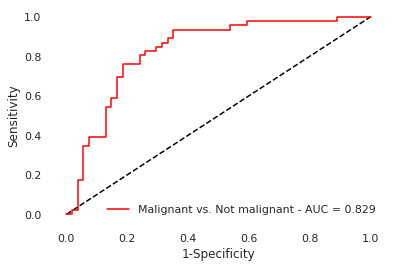

In [22]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-test-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Test precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-test-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

In [ ]:
import json
hyperparameters = json.loads(result.hyperparameters)
deep_top = hyperparameters["deep-dense-top"]
grad_cam_layer = "dense_3"
if deep_top: 
    grad_cam_layer = "dense_6"

# TSNE

In [ ]:
if result.input_form != "features": 
    layer = "dense_1"
    if deep_top: 
        layer = "dense_3"
    tsne_dataset = train
    tsne_dataset.reset()
    fieldnames = ["histographic interpretation"]
    tsne_results = ["malignant" if i else "benign" for i in transform_binary_predictions(get_results(model, tsne_dataset))]
    figs = plot_tsne(
        model, 
        layer, 
        tsne_dataset, 
        [tsne_results, tsne_dataset.labels], 
        fieldnames=["model output", *fieldnames], 
        perplexity=TSNE_PERPLEXITY,
    )
    for i, field in enumerate(["model output", *fieldnames]): 
        figs[i].savefig("figures/{}-{}-{}-tsne.svg".format(result.description, result.input_form, field.replace(" ", "-")), bbox_inches = "tight")
    tsne_dataset.reset()

# Grad Cam

In [ ]:
def show_grad_cam_images(images, labels, predictions, names=None, penultimate_layer="res5c_branch2c", layer="dense_3", columns=2, include_label=True):
    filter_idx = [0]
    grad_modifier = None
    backprop_modifier = None
    penultimate_layer_idx = None
    if penultimate_layer:
        penultimate_layer_idx = find_layer_idx(model, penultimate_layer)    
    rows = int(math.ceil(len(images) * 2/columns))
    f, ax = plt.subplots(rows, columns, figsize=(5.5, 3 * rows))    
    ax = ax.flatten()
    for i, image in enumerate(images): 
        grad = visualize_cam(
            model,
            find_layer_idx(model, layer),
            filter_idx,
            normalize(image),
            penultimate_layer_idx=penultimate_layer_idx,
            backprop_modifier=backprop_modifier,
            grad_modifier=grad_modifier)
        if names is not None: 
            ax[2*i].set_title("{}".format(names[i]))
        ax[2*i].imshow(image)
        ax[2*i].axis('off')
        if include_label: 
            ax[2*i+1].set_title("label/pred: {}/{}".format(labels[i], predictions[i]))
        ax[2*i+1].imshow(overlay(grad, image))
        ax[2*i+1].axis('off')
    return f, ax

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')